In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from models.class_network import deep_net

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device}")

using cuda


In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
# Constants

history_step = 15
output_step = 100

In [4]:
# Hyperparameters

batch_size = 128
epochs = 5

In [5]:
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(f"Number of batches: {len(train_dataloader)}")

Number of batches: 469


In [6]:
optimizers = [
    torch.optim.SGD,
    torch.optim.Adam,
    torch.optim.RMSprop
]

lrs = [0.01, 0.001, 0.01]

num_opts = len(optimizers)

In [7]:
from copy import deepcopy
model = deep_net(28*28, 10).to(device)
models = [deepcopy(model) for _ in range(num_opts)]
model_for_l2o = deepcopy(model)

In [8]:
loss_fn = nn.CrossEntropyLoss()

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    history = []
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.reshape(-1, 28 * 28)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()

        if batch % output_step == 0:
            current = batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

        if batch % history_step == 0:
            history.append(loss)
            
    return history

In [10]:
his = [[] for _ in range(num_opts)]
for i in range(num_opts):
    print(f"Using {optimizers[i].__name__}")
    for t in range(epochs):
        print(f"Epoch {t+1}: ")
        
        loss = train(
            train_dataloader,
            models[i],
            loss_fn,
            optimizers[i](models[i].parameters(), lr=lrs[i]))

        his[i].append(loss)

    print("Done!\n")

Using SGD
Epoch 1: 
loss: 2.306220  [    0/60000]
loss: 2.280006  [12800/60000]
loss: 2.221151  [25600/60000]
loss: 2.115293  [38400/60000]
loss: 2.043834  [51200/60000]
Epoch 2: 
loss: 1.904550  [    0/60000]
loss: 1.827815  [12800/60000]
loss: 1.531813  [25600/60000]
loss: 1.303977  [38400/60000]
loss: 1.119820  [51200/60000]
Epoch 3: 
loss: 0.942343  [    0/60000]
loss: 0.901653  [12800/60000]
loss: 0.693841  [25600/60000]
loss: 0.653321  [38400/60000]
loss: 0.702186  [51200/60000]
Epoch 4: 
loss: 0.584436  [    0/60000]
loss: 0.592828  [12800/60000]
loss: 0.482520  [25600/60000]
loss: 0.487778  [38400/60000]
loss: 0.572737  [51200/60000]
Epoch 5: 
loss: 0.452756  [    0/60000]
loss: 0.454902  [12800/60000]
loss: 0.394922  [25600/60000]
loss: 0.417836  [38400/60000]
loss: 0.513000  [51200/60000]
Done!

Using Adam
Epoch 1: 
loss: 2.306220  [    0/60000]
loss: 0.645805  [12800/60000]
loss: 0.368929  [25600/60000]
loss: 0.324541  [38400/60000]
loss: 0.349309  [51200/60000]
Epoch 2: 
lo

In [11]:
for i in range(num_opts):
    his[i] = torch.tensor(his[i]).reshape(-1)

## Using L2O Optimizer

In [12]:
from models.l2o_optimizer import lstm_l2o_optimizer   

In [13]:
l2o_optimizer = lstm_l2o_optimizer().to(device)
l2o_optimizer.load_state_dict(torch.load("trained_model/l2o_optimizer.pth"))
l2o_optimizer.eval()

lstm_l2o_optimizer(
  (LSTM): LSTM(1, 24)
  (linear): Linear(in_features=24, out_features=1, bias=True)
)

In [14]:
def init_hidden(model):
    # Initializes a hidden state dictionary for every parameter value in the model.
    h = {}

    for m_key in model._modules:
        modules = model._modules[m_key]
        h_module = {}
        for p_key in modules._parameters:
            h_module[p_key] = None
        h[m_key] = h_module
    
    return h

In [15]:
def update_weights(model, update_fn, hidden):
    with torch.no_grad():
        for m_key in model._modules:
            m1 = model._modules[m_key]
            h_module = hidden[m_key]
            for p_key in m1._parameters:
                
                grad_in = m1._parameters[p_key].grad.reshape(1, -1, 1)

                update, h_module[p_key] = update_fn(grad_in, h_module[p_key])        
                update = update.reshape(m1._parameters[p_key].shape)
                
                m1._parameters[p_key] -= update 

In [16]:
def zero_gradients(model):
    for m_key in model._modules:
        m1 = model._modules[m_key]
        for p_key in m1._parameters:
            # Shape for Batch input: (1, Num, 1)
            # Shape for Hidden State: (1, Num, 24)
            
            if m1._parameters[p_key].grad is not None:
                m1._parameters[p_key].grad.zero_()

In [17]:
def train_with_l2o(dataloader, model, loss_fn, l2o_optimizer):
    h = init_hidden(model)
    size = len(dataloader.dataset)
    history = []
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        # Preprocessing
        X = X.reshape(-1, 28 * 28)
        X, y = X.to(device), y.to(device)

        # Forward Pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        zero_gradients(model)
        loss.backward()
        update_weights(model, l2o_optimizer, h)

        loss = loss.item()

        if batch % output_step == 0:
            current = batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

        if batch % history_step == 0:
            history.append(loss)

    return history

In [18]:
l2o_hist = []
for i in range(epochs):
    print(f"Epoch: {i + 1}")
    loss = train_with_l2o(
        train_dataloader,
        model_for_l2o,
        loss_fn,
        l2o_optimizer)

    l2o_hist.append(loss)


Epoch: 1
loss: 2.306220  [    0/60000]
loss: 1.065172  [12800/60000]
loss: 0.428117  [25600/60000]
loss: 0.379430  [38400/60000]
loss: 0.454525  [51200/60000]
Epoch: 2
loss: 0.285010  [    0/60000]
loss: 0.245924  [12800/60000]
loss: 0.255019  [25600/60000]
loss: 0.269696  [38400/60000]
loss: 0.353664  [51200/60000]
Epoch: 3
loss: 0.188400  [    0/60000]
loss: 0.177503  [12800/60000]
loss: 0.211812  [25600/60000]
loss: 0.218001  [38400/60000]
loss: 0.293230  [51200/60000]
Epoch: 4
loss: 0.150007  [    0/60000]
loss: 0.142936  [12800/60000]
loss: 0.179414  [25600/60000]
loss: 0.195924  [38400/60000]
loss: 0.248379  [51200/60000]
Epoch: 5
loss: 0.126670  [    0/60000]
loss: 0.126375  [12800/60000]
loss: 0.146927  [25600/60000]
loss: 0.172535  [38400/60000]
loss: 0.218157  [51200/60000]


### Plotting Results

In [19]:
from matplotlib import pyplot as plt

In [28]:
l2o_hist = torch.tensor(l2o_hist).reshape(-1)
his.append(l2o_hist)

In [21]:
names = [optimizers[i].__name__ for i in range(num_opts)]
names.append("L2O-LSTM")

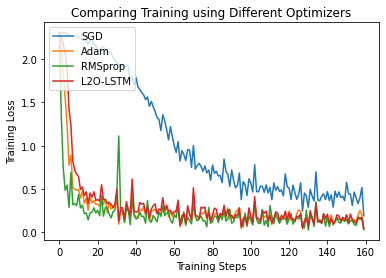

In [31]:
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('Comparing Training using Different Optimizers')
for i in range(num_opts + 1):
    plt.plot(his[i], label=names[i])

plt.legend(loc="upper left")
plt.show()